
## Parte B



In [3]:
import os
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import yaml
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
from pyathena import connect

In [7]:
session = boto3.Session(region_name="us-east-1")
s3 = session.client("s3")

# Definir las variables de entorno necesarias para AWS
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

# Tu configuración personalizada
BUCKET_NAME = "itam-analytics-sofia"
FOLDER_NAME = "profeco/athena_queries"         # Carpeta para guardar queries
FILE = "query_basicos.sql"                     # Nombre del archivo SQL

# Athena
DATABASE_NAME = "profeco_db"
TABLE_NAME = "profeco"
BUCKET_QUERY = f"s3://{BUCKET_NAME}/athena_staging/"  # Carpeta para resultados temporales de Athena


In [8]:
from pyathena import connect
import pandas as pd

conn = connect(s3_staging_dir=BUCKET_QUERY, region_name="us-east-1")

df = pd.read_sql(f"SELECT * FROM {DATABASE_NAME}.{TABLE_NAME} LIMIT 10", conn)
print(df.head())


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/656886452.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM {DATABASE_NAME}.{TABLE_NAME} LIMIT 10", conn)


  producto marca                 tipo     precio       fecha  \
0  mojarra   s/m  pescados y mariscos  84.900002  2019-01-09   
1  mojarra   s/m  pescados y mariscos  82.900002  2018-08-07   
2  mojarra   s/m  pescados y mariscos  59.900002  2019-01-09   
3  mojarra   s/m  pescados y mariscos  86.000000  2019-01-10   
4  mojarra   s/m  pescados y mariscos  82.900002  2018-08-09   

                estado    ciudad             catalogo  anio  
0      baja california  ensenada  pescados y mariscos  2019  
1  baja california sur    la paz  pescados y mariscos  2018  
2      baja california  ensenada  pescados y mariscos  2019  
3      baja california  ensenada  pescados y mariscos  2019  
4  baja california sur    la paz  pescados y mariscos  2018  


------

¿De qué año a qué año tienes datos de la categoría?

In [13]:
query_rango_anios = """
SELECT MIN(anio) AS anio_min, MAX(anio) AS anio_max
FROM profeco_db.profeco
WHERE catalogo = 'basicos'
"""

df_rango_anios = pd.read_sql(query_rango_anios, conn)
df_rango_anios



/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/2835520016.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rango_anios = pd.read_sql(query_rango_anios, conn)


,anio_min,anio_max
0,2018,2024


¿Cuántos registros de fecha hay vacíos?


In [14]:
query_fechas_nulas = """
SELECT COUNT(*) AS registros_fecha_vacia
FROM profeco_db.profeco
WHERE catalogo = 'basicos' AND fecha IS NULL
"""

df_fechas_nulas = pd.read_sql(query_fechas_nulas, conn)
df_fechas_nulas


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/1345368731.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fechas_nulas = pd.read_sql(query_fechas_nulas, conn)


,registros_fecha_vacia
0,0


¿Cuántos registros tienes por año?


In [15]:
query_registros_anio = """
SELECT anio, COUNT(*) AS total_observaciones
FROM profeco_db.profeco
WHERE catalogo = 'basicos'
GROUP BY anio
ORDER BY anio
"""

df_registros_anio = pd.read_sql(query_registros_anio, conn)
df_registros_anio


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/1326948483.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_registros_anio = pd.read_sql(query_registros_anio, conn)


,anio,total_observaciones
0,2018,8802747
1,2019,7398860
2,2020,6170515
3,2021,6919470
4,2022,7945081
5,2023,7742108
6,2024,1986577


¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año??


In [16]:
query_estadisticas_precio = """
SELECT 
  anio,
  MIN(precio) AS precio_min,
  MAX(precio) AS precio_max,
  AVG(precio) AS precio_prom,
  STDDEV(precio) AS precio_std,
  APPROX_PERCENTILE(precio, 0.25) AS q25,
  APPROX_PERCENTILE(precio, 0.5) AS mediana,
  APPROX_PERCENTILE(precio, 0.75) AS q75
FROM profeco_db.profeco
WHERE catalogo = 'basicos'
GROUP BY anio
ORDER BY anio
"""

df_estadisticas_precio = pd.read_sql(query_estadisticas_precio, conn)
df_estadisticas_precio


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/1841337668.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_estadisticas_precio = pd.read_sql(query_estadisticas_precio, conn)


,anio,precio_min,precio_max,precio_prom,precio_std,q25,mediana,q75
0,2018,1.0,899.000000,46.446708,48.807092,16.927554,29.899801,54.268995
1,2019,1.0,659.900024,47.617151,50.498669,16.961205,30.466560,56.152510
2,2020,1.0,844.900024,51.223467,53.187706,18.837811,32.911887,61.339545
3,2021,1.0,798.900024,53.788600,56.237502,19.919440,34.081955,64.551450
4,2022,1.0,690.000000,59.717037,62.383893,22.739023,38.739689,71.265393
5,2023,1.2,869.000000,65.701468,68.851441,24.536322,41.958782,79.508101
6,2024,1.3,799.000000,66.911763,70.214783,25.120559,42.541486,80.303084


¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?


In [17]:
query_top5_avg_precio_estado = """
WITH avg_price_table AS (
    SELECT
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' 
            ELSE marca 
        END AS marca_normalizada,
        estado,
        AVG(precio) AS precio_promedio
    FROM profeco_db.profeco
    WHERE catalogo = 'basicos' AND precio IS NOT NULL
    GROUP BY 1, 2
),
top5_table AS (
    SELECT
        marca_normalizada,
        estado,
        precio_promedio,
        ROW_NUMBER() OVER(PARTITION BY estado ORDER BY precio_promedio DESC) AS row_num
    FROM avg_price_table
)
SELECT
    marca_normalizada AS marca,
    estado,
    precio_promedio,
    row_num
FROM top5_table
WHERE row_num <= 5
ORDER BY estado, row_num;
"""

df_top5_avg_precio_estado = pd.read_sql(query_top5_avg_precio_estado, conn)
df_top5_avg_precio_estado.head()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/2058197693.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top5_avg_precio_estado = pd.read_sql(query_top5_avg_precio_estado, conn)


,marca,estado,precio_promedio,row_num
0,saba cup,aguascalientes,573.354167,1
1,diva cup 2,aguascalientes,541.109985,2
2,diva cup 1,aguascalientes,505.576660,3
3,jose cuervo tradicional,aguascalientes,368.824086,4
4,torres 10,aguascalientes,321.291528,5


¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?


In [18]:
query_top5_cdmx = """
WITH precios_cdmx AS (
    SELECT
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada,
        AVG(precio) AS precio_promedio
    FROM profeco_db.profeco
    WHERE estado = 'ciudad de mexico'
      AND catalogo = 'basicos'
      AND precio IS NOT NULL
    GROUP BY 1
),
top5_menor_precio AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY precio_promedio ASC) AS row_num
    FROM precios_cdmx
)
SELECT marca_normalizada AS marca, precio_promedio
FROM top5_menor_precio
WHERE row_num <= 5
ORDER BY precio_promedio ASC;
"""

df_top5_cdmx = pd.read_sql(query_top5_cdmx, conn)
df_top5_cdmx.head()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/151312075.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top5_cdmx = pd.read_sql(query_top5_cdmx, conn)


,marca,precio_promedio
0,frutimax,2.356471
1,clight,3.165304
2,livean,3.331468
3,froot loops. kellogg s,3.873237
4,zuko,4.149821


¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?


In [19]:
query_top5_mas_obs = """
WITH marcas_limpias AS (
    SELECT 
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco_db.profeco
    WHERE catalogo = 'basicos'
)
SELECT 
    marca_normalizada AS marca,
    COUNT(*) AS total_observaciones
FROM marcas_limpias
GROUP BY 1
ORDER BY total_observaciones DESC
LIMIT 5;
"""

df_top5_obs = pd.read_sql(query_top5_mas_obs, conn)
df_top5_obs.head()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/506329511.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top5_obs = pd.read_sql(query_top5_mas_obs, conn)


,marca,total_observaciones
0,s/m,2762896
1,la costena,1311439
2,fud,1151109
3,bimbo,819491
4,lala,750135


In [20]:
query_top_marca_estado = """
WITH marcas_limpias AS (
    SELECT 
        estado,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco_db.profeco
    WHERE catalogo = 'basicos'
),
ranking AS (
    SELECT 
        estado,
        marca_normalizada AS marca,
        COUNT(*) AS total_obs,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY COUNT(*) DESC) AS row_num
    FROM marcas_limpias
    GROUP BY estado, marca_normalizada
)
SELECT estado, marca, total_obs
FROM ranking
WHERE row_num <= 1
ORDER BY total_obs DESC;
"""

df_top_marca_estado = pd.read_sql(query_top_marca_estado, conn)
df_top_marca_estado.head()


/var/folders/8v/p9jmdytd6y36kdsq55l4_cqw0000gn/T/ipykernel_37036/462689651.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_marca_estado = pd.read_sql(query_top_marca_estado, conn)


,estado,marca,total_obs
0,ciudad de mexico,s/m,672470
1,estado de mexico,s/m,451509
2,jalisco,s/m,122279
3,guanajuato,s/m,97015
4,nuevo leon,s/m,86329


Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.


In [22]:
query_top5 = """
WITH marcas_limpias AS (
    SELECT 
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco_db.profeco
    WHERE catalogo = 'basicos'
)
SELECT 
    marca_normalizada AS marca,
    COUNT(*) AS total_observaciones
FROM marcas_limpias
GROUP BY 1
ORDER BY total_observaciones DESC
LIMIT 5
"""

top5_df = wr.athena.read_sql_query(
    sql=query_top5,
    database=DATABASE_NAME,
    boto3_session=session
)

top5_marcas = top5_df["marca"].tolist()
print("Top 5 marcas:", top5_marcas)


Top 5 marcas: ['s/m', 'la costena', 'fud', 'bimbo', 'lala']


In [23]:
query_boxplot = f"""
SELECT 
    anio,
    marca,
    precio
FROM profeco_db.profeco
WHERE catalogo = 'basicos'
  AND marca IN ({','.join([f"'{m}'" for m in top5_marcas])})
  AND precio IS NOT NULL
  AND anio BETWEEN 2018 AND 2022
"""

df_boxplot = wr.athena.read_sql_query(
    sql=query_boxplot,
    database=DATABASE_NAME,
    boto3_session=session
)


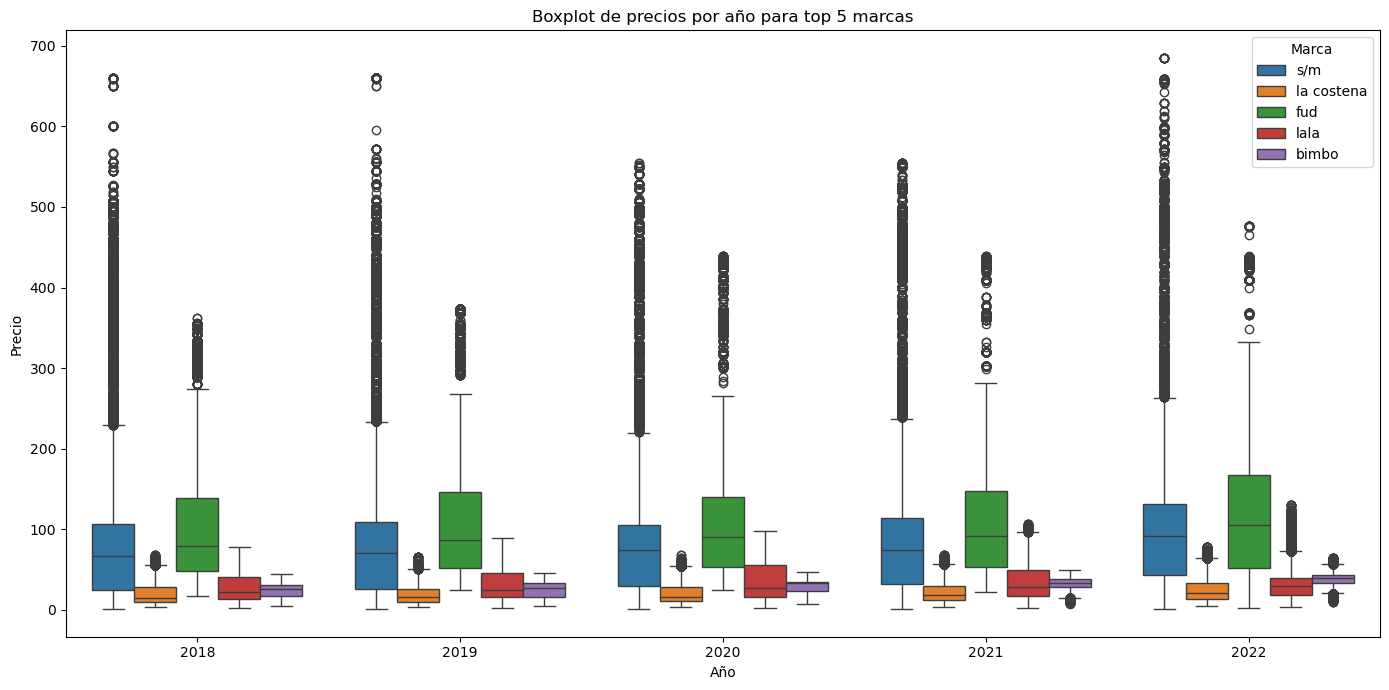

In [24]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_boxplot, x="anio", y="precio", hue="marca")
plt.title("Boxplot de precios por año para top 5 marcas")
plt.xlabel("Año")
plt.ylabel("Precio")
plt.legend(title="Marca")
plt.tight_layout()
plt.show()
